# Imports and Device

In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:3


# Load the data

In [3]:
root_path = "/scratch/04703/sravula/UTAFSDataNew/new_data"
chip_num = 48

In [4]:
import utils

data_dict = utils.grab_chip_data(root_path, chip_num, resample=True)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs', 'og_matrix', 'og_freqs'])

## Check the data matrices converted from touchstone to np

In [6]:
print(data_dict['gt_matrix'].shape)
print(data_dict['vf_matrix'].shape)
print(data_dict['y_matrix'].shape)
print(data_dict['og_matrix'].shape)

(4096, 12, 12, 2)
(3000, 12, 12, 2)
(26, 12, 12, 2)
(3000, 12, 12, 2)


In [7]:
print(data_dict['gt_matrix'].dtype)
print(data_dict['vf_matrix'].dtype)
print(data_dict['y_matrix'].dtype)
print(data_dict['og_matrix'].dtype)

float32
float32
float32
float32


In [8]:
print(data_dict['gt_freqs'].shape)
print(data_dict['y_freqs'].shape)
print(data_dict['og_freqs'].shape)

(4096,)
(26,)
(3000,)


In [9]:
print(data_dict['gt_freqs'].dtype)
print(data_dict['y_freqs'].dtype)
print(data_dict['og_freqs'].dtype)

float64
float64
float64


## Convert the raw data matrices to only the unique S-parameters

In [10]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])
og_data = utils.matrix_to_sparams(data_dict['og_matrix'])

In [11]:
print(vf_data.shape)
print(gt_data.shape)
print(y_data.shape)
print(og_data.shape)

(78, 2, 3000)
(78, 2, 4096)
(78, 2, 26)
(78, 2, 3000)


In [12]:
print(vf_data.dtype)
print(gt_data.dtype)
print(y_data.dtype)
print(og_data.dtype)

float32
float32
float32
float32


In [13]:
og_freqs = data_dict['og_freqs']
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

In [14]:
print(og_freqs.shape)
print(gt_freqs.shape)
print(y_freqs.shape)

(3000,)
(4096,)
(26,)


In [15]:
print(og_freqs.dtype)
print(gt_freqs.dtype)
print(y_freqs.dtype)

float64
float64
float64


## Plot the (re-sampled) Ground truth S-parameters 

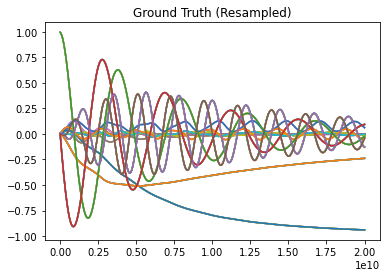

In [16]:
n_sparams = gt_data.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(gt_freqs, gt_data[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth (Resampled)")
plt.show()

In [17]:
gt_mag = utils.to_mag(torch.from_numpy(gt_data))

print(gt_mag.shape)

torch.Size([78, 4096])


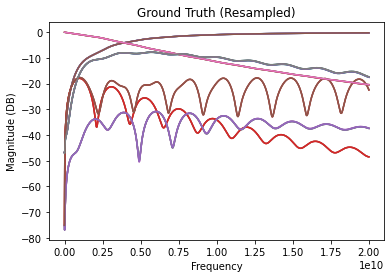

In [18]:
n_sparams = gt_mag.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_mag[i], label=str(i))
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth (Resampled)")
plt.ylabel("Magnitude (DB)")
plt.xlabel("Frequency")
plt.show()

## Check the data for some smoothness and regularity conditions

In [19]:
def calc_diffs(x, order=1):
    if order > 1:
        x = calc_diffs(x, order-1)
    
    if isinstance(x, np.ndarray):
        return (x - np.roll(x, -1, 2))[...,:-1] 
    elif torch.is_tensor(x):
        return (x - torch.roll(x, -1, 2))[...,:-1]

(78, 2, 4095)


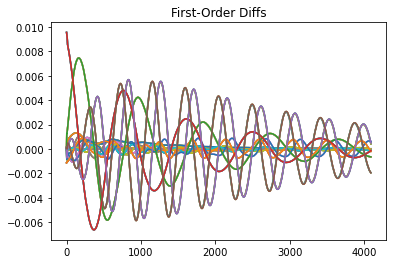

In [20]:
x_diff_1 = calc_diffs(gt_data)

print(x_diff_1.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_1[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_1[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("First-Order Diffs")
plt.show()

(78, 2, 4094)


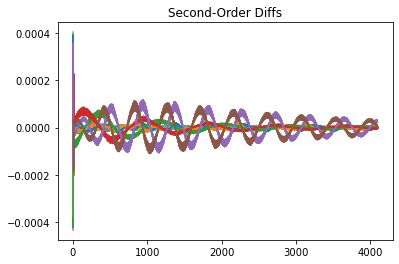

In [21]:
x_diff_2 = calc_diffs(gt_data, 2)

print(x_diff_2.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_2[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_2[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Second-Order Diffs")
plt.show()

## Grab some measurements

In [22]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full]
LENGTH = len(gt_freqs)
M = int(data_dict['y_freqs'].shape[0] * (gt_freqs.shape[0] / og_freqs.shape[0])) #proportional to amount VF gets

In [23]:
kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, LENGTH, M)

In [24]:
print(LENGTH)
print(M)
print(len(kept_inds))
print(len(missing_inds))

4096
35
36
4060


## Make the final data

In [25]:
x = torch.from_numpy(gt_data)
x = x.view(-1, LENGTH).unsqueeze(0)

In [26]:
print(x.shape)
print(x.dtype)

torch.Size([1, 156, 4096])
torch.float32


In [27]:
y = torch.clone(x)[:, :, kept_inds]

In [28]:
print(y.shape)
print(y.dtype)

torch.Size([1, 156, 36])
torch.float32


## Make sure that we can transform it back to the OG shape/size

In [29]:
x_temp = utils.sparams_to_matrix(x)
x_temp = x_temp.numpy()

In [30]:
print(x_temp.shape)
print(x_temp.dtype)

(4096, 12, 12, 2)
float32


In [31]:
print(np.square(np.subtract(x_temp, data_dict['gt_matrix'])).mean())

0.0


## Visualize the data and observations

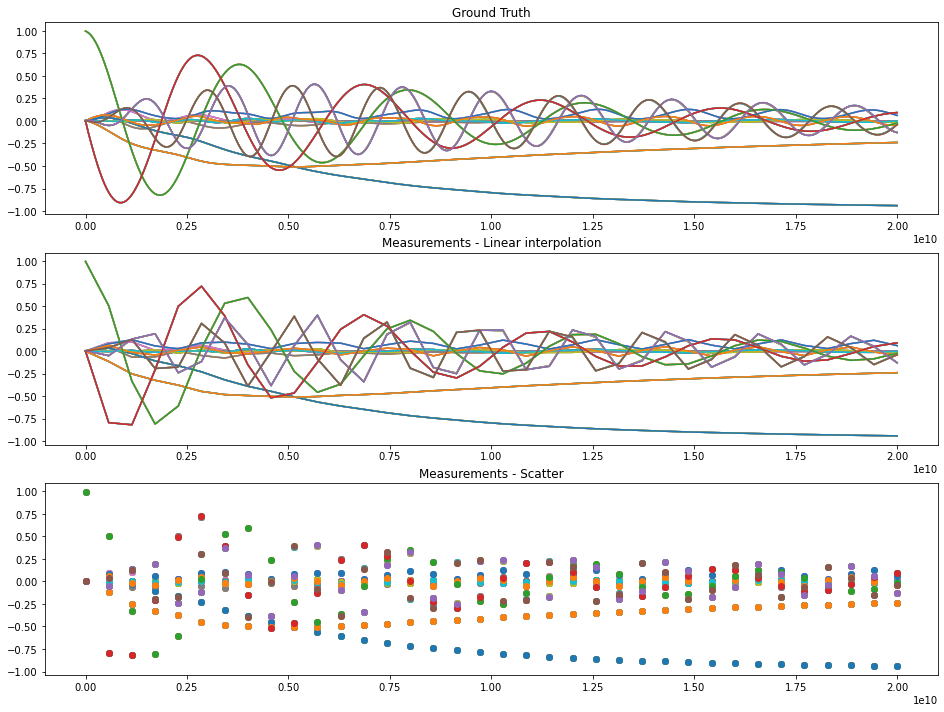

In [32]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs[kept_inds], y[j,i,:].flatten(), label=label)
axes[1].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].scatter(gt_freqs[kept_inds], y[j,i,:].flatten(), label=label)
axes[2].set_title("Measurements - Scatter")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

In [33]:
x_mag = utils.to_mag(x)
y_mag = utils.to_mag(y)

print(x_mag.shape)
print(y_mag.shape)

torch.Size([78, 4096])
torch.Size([78, 36])


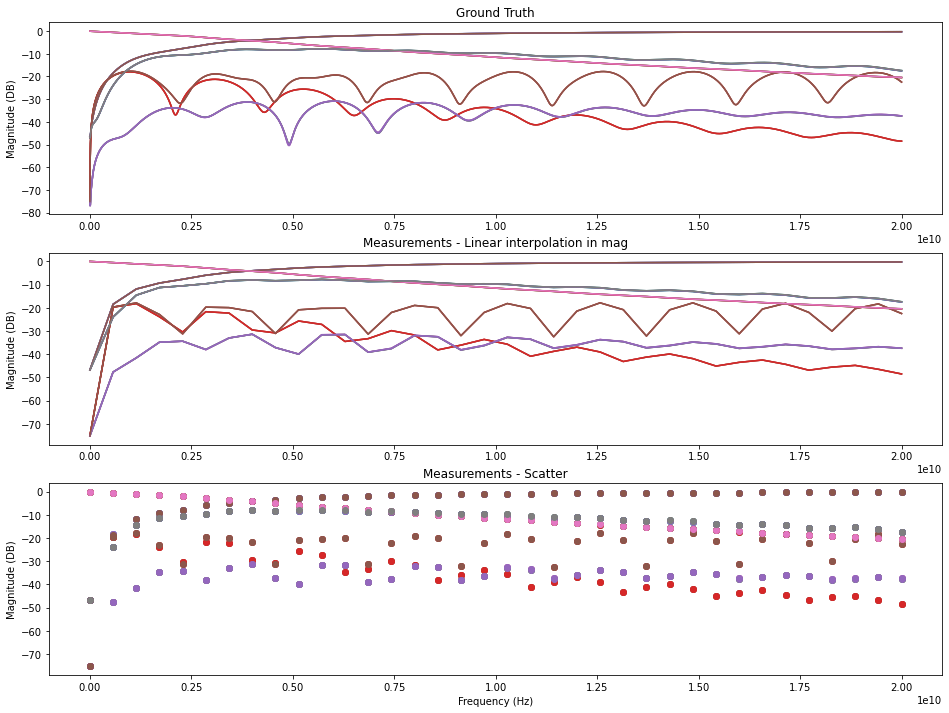

In [34]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs[kept_inds], y_mag[j], label=str(j))
axes[1].set_title("Measurements - Linear interpolation in mag")
axes[1].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].scatter(gt_freqs[kept_inds], y_mag[j], label=str(j))
axes[2].set_title("Measurements - Scatter")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

# Set up the network

In [35]:
LR = 1e-4 # learning rate
NUM_ITER = 10000 # number iterations

NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(LENGTH))) - 4
# NUM_LAYERS = int(np.ceil(np.log2(LENGTH)))
NUM_LAYERS = max(NUM_LAYERS, 5)

BASE_NGF = 2 ** int(np.ceil(np.log2(NZ)))
# BASE_NGF = NZ
BASE_NGF = max(BASE_NGF, 128)

# NGF = [int(BASE_NGF * 2**(2 * i / NUM_LAYERS)) for i in range(1, NUM_LAYERS+1)]
NGF = [int(BASE_NGF * 2**(i/2)) for i in range(NUM_LAYERS)]
# NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

In [36]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)

NZ:  156
NUM_LAYERS:  8
BASE NGF:  256
NGF:  [256, 362, 512, 724, 1024, 1448, 2048, 2896]
BS:  1
NC:  156


In [37]:
from models import RES_UNET

KERNEL_SIZE = 1

net = RES_UNET(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC, kernel_size=KERNEL_SIZE, num_layers=NUM_LAYERS)
net = net.to(device)

In [38]:
test_out = net.forward_with_z()
print(test_out.shape)

torch.Size([1, 156, 4096])


/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [39]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  93749560


# Make the linear interpolation and use it as the input to the network

In [40]:
import scipy

y_np = y.cpu().detach().numpy()

Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')

In [41]:
y_interp = Interpolate(np.arange(LENGTH))

print(y_interp.shape)

(1, 156, 4096)


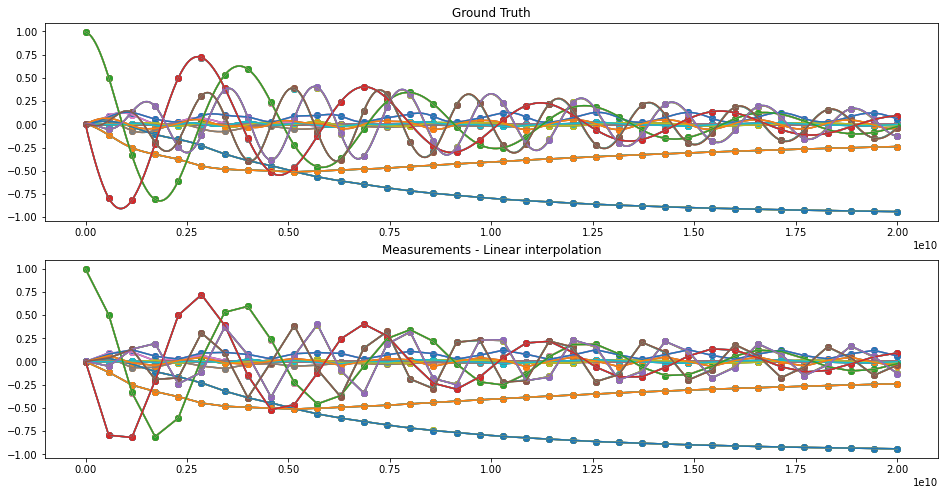

In [42]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, y_interp[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[1].legend()

plt.show()

In [43]:
y_interp_mag = utils.to_mag(torch.from_numpy(y_interp))

print(y_interp_mag.shape)

torch.Size([78, 4096])


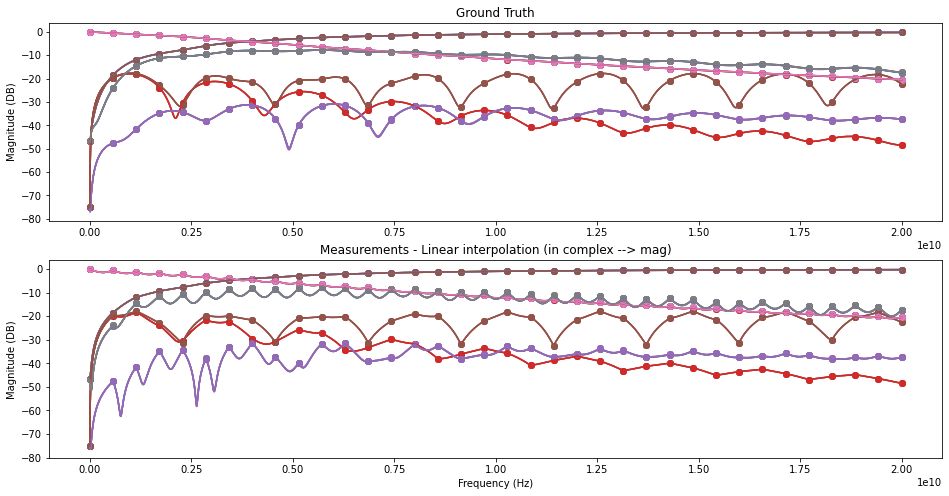

In [44]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j])
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j])
axes[1].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[1].legend()

plt.show()

In [45]:
net.set_z(y_interp)

y_interp = torch.from_numpy(y_interp)
y_interp = y_interp.to(device)

# Run

In [46]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=True, reduction="sum")
criterion = criterion.to(device)

regularizer = utils.Smoothing_Loss(per_param=True, reduction="sum")
regularizer = regularizer.to(device)

REG_HYPERPARAM = 100

In [47]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
train_errors = []
train_regs = []

test_mses = []
test_maes = []

# outputs = []

x = x.to(device)
y = y.to(device)

In [48]:
tic = time.time()
for i in range(NUM_ITER):
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    
    train_error = criterion(out, y) 
    train_reg = REG_HYPERPARAM * regularizer(out)
    train_loss = train_error + train_reg
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
#         outputs.append(out.detach().clone().cpu())
        
        train_losses.append(train_loss.item())
        train_errors.append(train_error.item())
        train_regs.append(train_reg.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%1000 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ITER  0
TIME:  0.0887753963470459

ITER  999
TIME:  47.73102140426636

ITER  1999
TIME:  95.41425776481628

ITER  2999
TIME:  143.1058051586151

ITER  3999
TIME:  190.79348254203796

ITER  4999
TIME:  238.48764371871948

ITER  5999
TIME:  286.1744418144226

ITER  6999
TIME:  333.8724572658539

ITER  7999
TIME:  381.56354546546936

ITER  8999
TIME:  429.25508737564087

ITER  9999
TIME:  476.94729566574097



# Plot the last and best outputs and the metrics

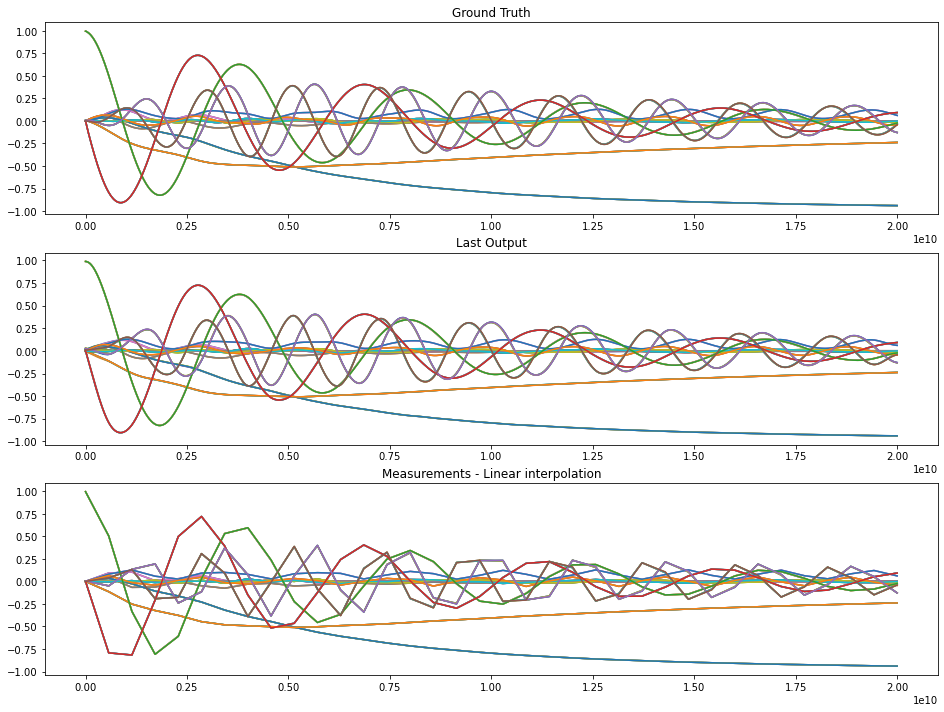

In [49]:
out = out.detach().clone().cpu()

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
#         axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
#         axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Last Output")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten(), label=label)
#         axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[2].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

In [50]:
out_mag = utils.to_mag(out)

print(out_mag.shape)

torch.Size([78, 4096])


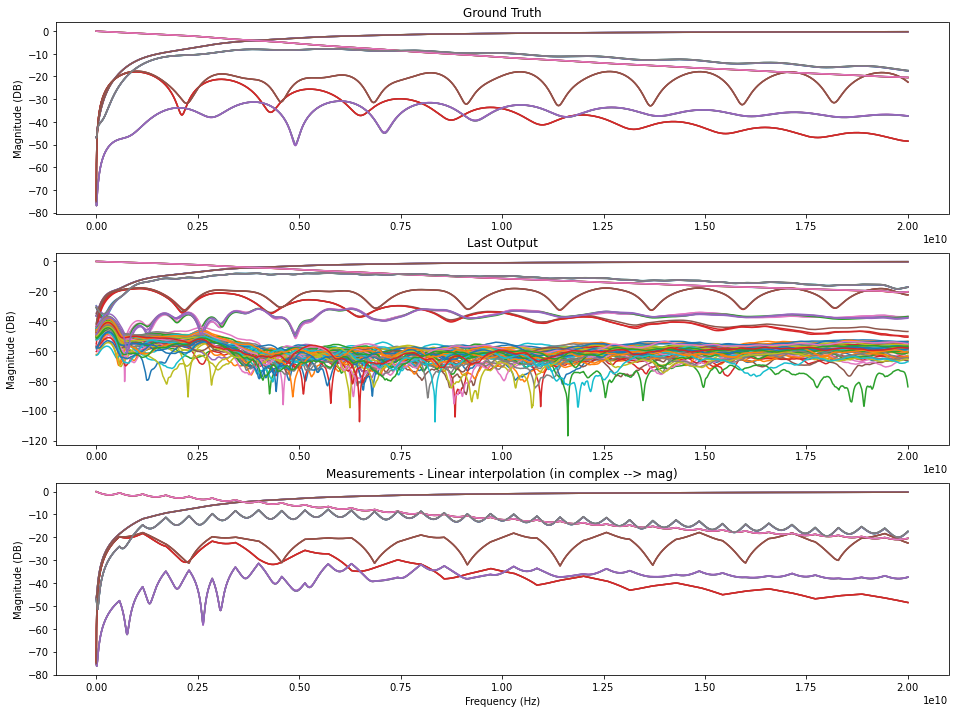

In [51]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
#     axes[0].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, out_mag[j], label=str(j))
#     axes[1].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[1].set_title("Last Output")
axes[1].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
#     axes[2].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

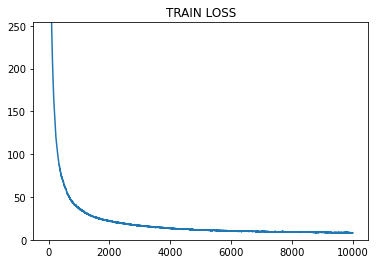

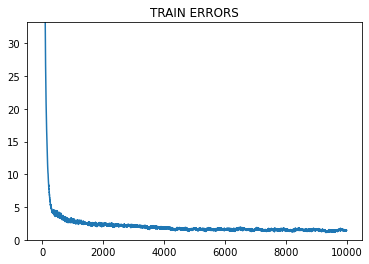

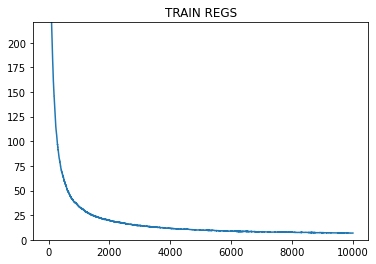

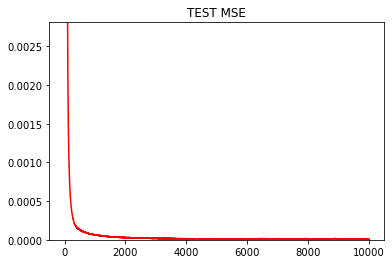

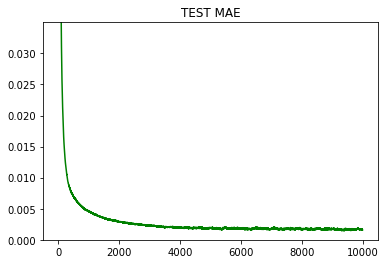

In [52]:
max_idx = 100 #np.argmax(train_losses)

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

plt.figure()
plt.plot(train_regs)
plt.title("TRAIN REGS")
plt.ylim(0., train_regs[max_idx])
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

# Calculate Metrics between DIP, Vector Fit, Linear Interpolation, and the Ground Truth 

In [53]:
print(test_mses[-1])

1.1019275007129181e-05


In [54]:
print(torch.nn.MSELoss()(x, y_interp))

tensor(0.0002, device='cuda:3', dtype=torch.float64)


In [55]:
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)

INTERP_MATRIX = utils.sparams_to_matrix(y_interp)

In [56]:
print(DIP_OUT_MATRIX.shape)
print(INTERP_MATRIX.shape)

torch.Size([4096, 12, 12, 2])
torch.Size([4096, 12, 12, 2])


In [57]:
print(gt_freqs.shape)
print(og_freqs.shape)

(4096,)
(3000,)


In [58]:
DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(chip_num), og_freqs)

INTERP_net = utils.matrix_to_network(INTERP_MATRIX, gt_freqs, "Linear Interpolation With "+str(M)+" Samples for Chip "+str(chip_num), og_freqs)

In [59]:
DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)

INTERP_FINAL_OUT = np.stack((INTERP_net.s.real, INTERP_net.s.imag), axis=-1)

In [60]:
print(DIP_FINAL_OUT.shape)
print(INTERP_FINAL_OUT.shape)

(3000, 12, 12, 2)
(3000, 12, 12, 2)


In [61]:
dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
interp_data = utils.matrix_to_sparams(INTERP_FINAL_OUT)

In [62]:
print(dip_data.shape)
print(interp_data.shape)

(78, 2, 3000)
(78, 2, 3000)


In [63]:
print(dip_data.dtype)
print(interp_data.dtype)

float32
float32


In [64]:
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

data_range = np.amax(og_data) - np.amin(og_data)

psnr_ours = psnr(og_data, dip_data)#, data_range)
psnr_interp = psnr(og_data, interp_data)#, data_range)
psnr_vf = psnr(og_data, vf_data)#, data_range)

In [65]:
print("DIP PSNR: ", psnr_ours)
print("INTERP PSNR: ", psnr_interp)
print("VF PSNR: ", psnr_vf)

DIP PSNR:  55.59522841701133
INTERP PSNR:  42.446499122981095
VF PSNR:  58.19819045187969


In [66]:
# DIP_net.write_touchstone(root_path+"/DIP_"+str(chip_num))
# INTERP_net.write_touchstone(root_path+"/INTERP_"+str(chip_num))